# EEG Processing Exploration
# Interactive exploration of EEG processing pipeline stages

In [1]:
# Initial imports
from src.eeg_processor.pipeline import EEGPipeline

In [2]:
# Initialize processor
pipeline = EEGPipeline()

## Load Raw Data

2025-05-22 10:09:57,958 - file_io.curry - INFO - Loading Curry file: S_003_F.dat


Leaving device<->head transform as None (no landmarks found)
Reading 0 ... 2561399  =      0.000 ...  2561.399 secs...
Event file found. Extracting Annotations from C:\Users\sayee\Documents\Research\PythonCode\EEG_Processor\tests\test_data\curry\S_003_F.ceo...
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 66 EEG, 1 misc
 custom_ref_applied: False
 dig: 69 items (3 Cardinal, 66 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2024-04-05 11:09:07 UTC
 nchan: 67
 projs: []
 sfreq: 1000.0 Hz
>


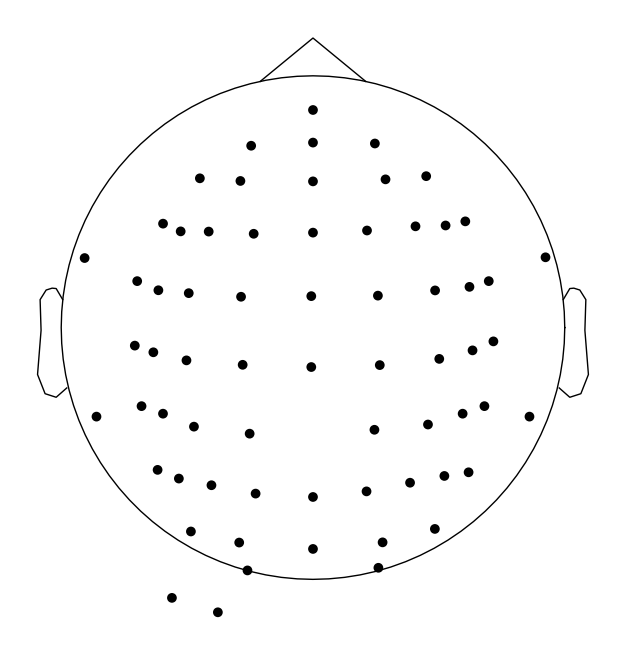

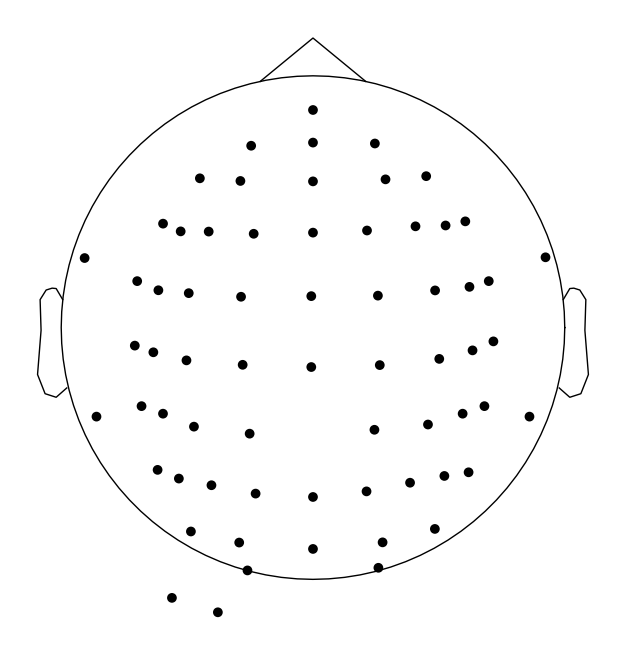

In [4]:
# Direct file loading (alternative if participant handler isn't working)
raw_data_path = 'C:/Users/sayee/Documents/Research/PythonCode/EEG_Processor/tests/test_data/curry/'
participant_file = 'S_003_F.dat'

raw = pipeline.load_raw(raw_data_path + participant_file)
print(raw.info)
raw.plot_sensors()


Plot psd graph for all electrodes

In [ ]:
nyquist = raw.info["sfreq"] / 2
raw.compute_psd(fmax=nyquist).plot()

### Plot the raw data (decimated for plotting speed)

In [ ]:
raw_decimated = raw.copy().resample(sfreq=300)
raw_decimated.plot()


## Processing Pipeline


### Cropping Stage

In [ ]:
crop_params = {
    'crop_after': 30,
    'crop_before': 39,
}

cond3 = pipeline.apply_stage(raw, "crop", **crop_params) # applying a stage modifies the raw object directly

### Filtering Stage


In [ ]:
# Apply filter
filter_params = {
    'l_freq': 1,
    'h_freq': 20,
}

filtered = pipeline.apply_stage(cond3, "filter", **filter_params)
filtered.compute_psd(fmax=80).plot()


### Bad Channel Detection


In [ ]:
# Detect bad channels
bad_ch_params = {
    'segment_wise': False,
    'verbose': True,
    'interpolate': True
}

clean = pipeline.apply_stage(filtered, "detect_bad_channels", **bad_ch_params)
print(clean.info)

### Re-referencing


In [ ]:
# Apply average reference
reref_params = {
    'method': 'average',
    'exclude': ['EOG']  # List channels to exclude
}

rereferenced = pipeline.apply_stage(clean, "rereference", **reref_params)
print(rereferenced.info)


### ICA blink removal


In [ ]:
# Apply ica blink correction
ica_params = {
    'method': 'ica',
}

corrected = pipeline.apply_stage(rereferenced, "blink_artifact", **ica_params)
print(corrected.info)

### Plot Data Before Epoching

In [ ]:
corrected.plot()

### Epoching


In [ ]:
# Define condition and epoch
condition = {
    "name": "Inhibition",
    "epoch_events": {"Stim": 31, "Silence": 32},
    "condition_markers": [30, 39],
}

epoch_params = {
    'tmin': -0.2,
    'tmax': 0.6,
    'baseline': [-0.1, 0],
    'reject': {'eeg': 250e-6},
}


# Set condition and epoch
pipeline.processor.set_condition(condition)
epochs = pipeline.apply_stage(corrected, "epoch", **epoch_params)
epochs.plot_drop_log()

### Plot some diagnostic figures

In [ ]:
epochs.plot_image(picks='Oz')
epochs.plot_psd(fmax=30)
epochs.compute_psd().plot_topomap()

## Average across Epochs

In [ ]:
stim_evoked = epochs['Stim'].average()
sil_evoked = epochs['Silence'].average()

import mne
mne.viz.plot_compare_evokeds([stim_evoked, sil_evoked])